In [1]:
import scipy.optimize as opt
import scipy.special as spec
import numpy as np
from math import *
import matplotlib.pyplot as plt
from DataSet import generateDataSet
from igraph import *
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')
from igraph import *
from DataSet import generateDataSet
import copy

In [2]:
## Compute the lambdas
def strength(i,j,p,vec):
    summ = 0
    for l in range(p):
        summ += vec[i,l]*vec[j,l]
    return summ

# n : Population / p : Number of communities / k : Number of ranks / a,b : Gamma parameters / w = Community parameter
#/ rho : Data rho[i,j] jth selection of the ith person
def posterior(n,p,k,w,rho):
    wPrior = w[:(p+1)]
    wLH = w[(p+1):]
    vec = wLH.reshape((n,p))
    summa = 0
    for i in range(n):
        for u in range(p):
            if vec[i,u] == 0:
                summa += (wPrior[0]-1)*log(0.0000000001) - wPrior[1 + u]*vec[i,u] + wPrior[0]*log(wPrior[1 + u]) - spec.gamma(wPrior[0])
            else:
                summa += (wPrior[0]-1)*log(abs(vec[i,u])) - wPrior[1 + u]*vec[i,u] + wPrior[0]*log(wPrior[1 + u]) - spec.gamma(wPrior[0])
        totalStrength = 0
        listIndex = [l for l in range(n)]
        del listIndex[i]
        for u in (listIndex):
            totalStrength += strength(i,u,p,vec)
        stateStrength = 0
        for j in range(k):
            totalStrength -= stateStrength
            summa -= log(abs(totalStrength))
            stateStrength = strength(i,rho[i,j],p,vec)
            summa += log(abs(stateStrength))
    return summa

def posteriorNoDegree(n,p,k,a,b,w,rho):
    vec = w.reshape((n,p))
    summa = 0
    for i in range(n):
        for u in range(p):
            if vec[i,u] == 0:
                summa += (a-1)*log(0.0000000001) - b*vec[i,u]
            else:
                summa += (a-1)*log(abs(vec[i,u])) - b*vec[i,u]
        totalStrength = 0
        listIndex = [l for l in range(n)]
        del listIndex[i]
        for u in (listIndex):
            totalStrength += strength(i,u,p,vec)
        stateStrength = 0
        for j in range(k):
            totalStrength -= stateStrength
            summa -= log(abs(totalStrength))
            stateStrength = strength(i,rho[i,j],p,vec)
            summa += log(abs(stateStrength))
    return summa

In [3]:
def drawGamma(a,b,n):
    return np.random.gamma(a,1/b,n)

def computeStrength(n,p,w):
    w1 = w.reshape((n,p))
    return (np.array([strength(i,j,p,w1) if i != j else 0 for i in range(n) for j in range(n)])).reshape((n,n))

def computeRho(strengthOrigin,n,K):
    strengths = np.array([[strengthOrigin[i,j] for j in range(n)] for i in range(n)])
    rho = np.zeros((n,K), dtype = int)
    for i in range(n):
        strength_i = strengths[i]
        strength_i_normalized = (1/(sum(strength_i)))*strength_i
        strength_i_cumulated = [(sum(strength_i_normalized[:(j+1)])) for j in range(n)]
        for j in range(K):
            r = np.random.rand()
            k = 0
            val = strength_i_cumulated[0]
            while r > val:
                k += 1
                val = strength_i_cumulated[k]
            rho[i,j] = k
            strengths[i,k] = 0
            strength_i = strengths[i]
            strength_i_normalized = (1/(sum(strength_i)))*strength_i
            strength_i_cumulated = [(sum(strength_i_normalized[:(l+1)])) for l in range(n)]
    return rho

def normalizeStrength(n,strengths):
    for i in range(n):
        strengths[i] = (1/sum(strengths[i]))*strengths[i]
    return strengths

def computeRealRho(strengths,n,K):
    rho = np.zeros((n,K), dtype = int)
    for i in range(n):
        listRank = [j for j in range(n)]
        strength_i = strengths[i]
        listRank = sorted(listRank, key=lambda b: strength_i[b])
        listRank.reverse()
        rho[i] = listRank[:K]
    return rho

def computeRemainingRho(strengthOrigin,n,rhoTest):
    t = len(rhoTest[0])
    strengths = np.array([[strengthOrigin[i,j] for j in range(n)] for i in range(n)])
    rho = np.zeros((n,n-1-t), dtype = int)
    for i in range(n):
        listRank = [u for u in range(n)]
        listRank.remove(i)
        strength_i = strengths[i]
        for taken in rhoTest[i]:
            listRank.remove(taken)
            np.delete(strength_i,taken)
        listRank = sorted(listRank, key = lambda b: strength_i[b])
        listRank.reverse()
        rho[i] = listRank
    return np.concatenate((rhoTest,rho),axis=1)


In [92]:
strengths = np.array([[0,10,19,20],[10,0,5,10], [19,5,0,3],[20,10,3,0]])
rhoTest = np.array([[1],[0],[1],[0]])
computeRemainingRho(strengths,4,rhoTest)

array([[1, 3, 2],
       [0, 3, 2],
       [1, 0, 3],
       [0, 1, 2]])

In [4]:
def mean(l):
    n = len(l)
    return (sum(l))/n

def AE(w1,w2,n):
    return (sum(map(lambda couple : abs(couple[0]-couple[1]) ,zip(w1,w2))))/n

def rankingGap(w1,w2,n):
    rk1 = [i for i in range(n)]
    rk2 = [i for i in range(n)]
    rk1 = sorted(rk1, key=lambda i: w1[i])
    rk2 = sorted(rk2, key=lambda i: w2[i])
    rk2 = [rk2.index(i) for i in rk1]
    return (sum(map(lambda couple : abs(couple[0]-couple[1]) ,zip([i for i in range(n)],rk2))))/n

In [5]:
def globalOpt(n,p,k,rho, w0 = 1):
    if type(w0) == int:
        w0 = 10*np.random.rand(n*p + p + 1)
    functionToOpt = lambda w : (-1)*posterior(n,p,k,w,rho)
    result = opt.fmin_l_bfgs_b(functionToOpt, w0,approx_grad=True, bounds = [(0.0000001, +inf) for i in range(n*p + p + 1)])
    return result

In [6]:
def optimizeCoor(n,p,k,rho,eps):
    w = 10*np.random.rand(n*p + p + 1)
    val = posterior(n,p,k,w,rho)
    flag2 = True
    flag = True
    while flag:
        for i in range(n*p + p + 1):
            w1 = np.delete(w,i)
            funcToOpt = lambda x : (-1)*posterior(n,p,k,np.insert(w1,i,x),rho)
            res, val1, msg = opt.fmin_l_bfgs_b(funcToOpt, np.array([w[i]]),approx_grad=True, bounds = [(0.000000000001,+inf)])
            if flag2:
                if val1 < 0:
                    flag2 = False
                    print("Original:",w)
                    print("Final:", np.insert(w1,i,res))
                    print("Difference:", w - np.insert(w1,i,res))
                    print("NUmber:", i)
            w = np.insert(w1,i,res)
        if abs(val1-val) < eps:
            print(val1)
            return w, val1
        else:
            val = val1
        print(val)

In [7]:
def optimizeCoorNoDegree(n,p,k,a,b,rho,eps):
    w = 10*np.random.rand(n*p)
    val = posteriorNoDegree(n,p,k,a,b,w,rho)
    flag = True
    while flag:
        for i in range(n*p):
            w1 = np.delete(w,i)
            funcToOpt = lambda x : (-1)*posteriorNoDegree(n,p,k,a,b,np.insert(w1,i,x),rho)
            res, val1, msg = opt.fmin_l_bfgs_b(funcToOpt, np.array([w[i]]),approx_grad=True, bounds = [(0,+inf)])
            w = np.insert(w1,i,res)
        if abs(val1-val) < eps:
            return w, val1
        else:
            val = val1

In [8]:
def globalOptNoDegree(n,p,k,a,b,rho):
    w0 = 10*np.random.rand(n*p)
    functionToOpt = lambda w : (-1)*posteriorNoDegree(n,p,k,a,b,w,rho)
    result = opt.fmin_l_bfgs_b(functionToOpt, w0,approx_grad=True, bounds = [(0.000000001, +inf) for i in range(n*p)])
    return result

## Simulation

[2.7199999999999998, 3.1911111111111112, 2.1599999999999997, 2.6311111111111107, 3.022222222222223, 2.648888888888889, 2.4, 2.497777777777777, 1.4577777777777776, 2.9688888888888894, 3.102222222222222, 2.7288888888888887, 2.853333333333333, 2.604444444444444, 2.0977777777777775, 3.7688888888888896, 2.0088888888888885, 2.9155555555555557, 2.782222222222222, 2.1333333333333333, 4.124444444444444, 2.746666666666667, 3.9111111111111114, 1.9644444444444444, 2.835555555555555, 2.8800000000000003, 2.4177777777777774, 3.173333333333334, 2.5244444444444443, 4.186666666666667, 3.4666666666666672, 1.8844444444444444, 3.5466666666666673, 4.017777777777778, 2.4177777777777782, 3.1022222222222227, 2.026666666666667, 2.3911111111111105, 3.2000000000000006, 3.0133333333333336, 3.831111111111111, 4.168888888888889, 4.506666666666666, 4.64, 2.6222222222222222, 2.6399999999999997, 2.08, 1.822222222222222, 3.102222222222222, 2.1155555555555554, 3.60888888888889, 3.9999999999999996, 2.684444444444444, 1.19

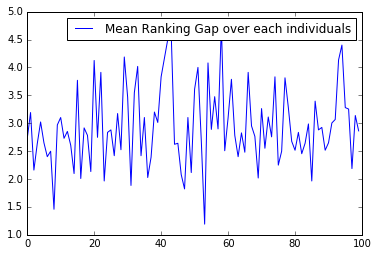

In [26]:
n = 15
p = 3
k = 4
a = 2
b = 2
listElementGap = []
listElementAE = []
numberSim = 100
for i in range(numberSim):
    gammaParameters = drawGamma(2,1,p+1)
    drawW = np.array([])
    for j in range(p):
        drawW = np.append(drawW, [drawGamma(gammaParameters[0], gammaParameters[j + 1], n)])
    drawW = drawW.reshape((p,n))
    drawW = drawW.T
    drawW = drawW.reshape((n*p,))
    w = drawW
    strengths = computeStrength(n,p,w)
    rho = computeRho(strengths,n,k)
    resultGlobal = globalOpt(n,p,k,rho)
    for j in range(15):
        resultGlobal = globalOpt(n,p,k,rho, w0 = resultGlobal[0])
    strengths = normalizeStrength(n,strengths)
    strengths = strengths.reshape((n*n,))
    strengthGlb = normalizeStrength(n,computeStrength(n,p,resultGlobal[0][(p+1):]))
    strengthGlb = strengthGlb.reshape((n*n,))
    listnGap = []
    listnAE = []
    for numInd in range(n):
        listnGap.append(rankingGap(strengths[numInd*n:(numInd+1)*n],strengthGlb[numInd*n:(numInd+1)*n],n))
        listnAE.append(AE(strengths[numInd*n:(numInd+1)*n],strengthGlb[numInd*n:(numInd+1)*n],n))
    listElementGap.append(mean(listnGap))
    listElementAE.append(mean(listnAE))
print(listElementGap)
print(listElementAE)

print("Mean Gap", mean(listElementGap))
print("Mean AE", mean(listElementAE))

plt.plot([i for i in range(numberSim)], listElementGap, '-b' ,label = 'Mean Ranking Gap over each individuals')
plt.legend()
plt.savefig("SimulationGap")
plt.show()

In [9]:
n = 25
p = 3
k = 4
a = 2
b = 2
gammaParameters = np.random.rand(4)*2 + 1
print(gammaParameters)
drawW = np.array([])
for j in range(p):
    drawW = np.append(drawW, [drawGamma(gammaParameters[0], gammaParameters[j + 1], n)])
drawW = drawW.reshape((p,n))
drawW = drawW.T
drawW = drawW.reshape((n*p,))
w = drawW
print(w)
strengths = computeStrength(n,p,w)
print(strengths)
rho = computeRho(strengths,n,k)
realRho = computeRealRho(strengths,n,k)

[1.52365345 1.08558978 2.56030798 2.52707765]
[0.32176337 0.23479944 0.56571247 0.51465264 0.88509951 0.66674655
 1.87771106 0.41905614 0.52186606 0.21338366 0.67962515 0.59693194
 4.13175553 0.51773233 0.2055853  0.51362541 0.62328035 0.82599345
 1.41749317 0.71605595 0.70420526 0.54198408 0.45920622 0.69776539
 1.78311781 1.18483787 0.50583421 0.258146   0.86683711 0.67713052
 4.37129427 0.18326625 0.1744885  1.11132306 0.49662994 0.12545198
 0.26879889 0.06181121 0.4717199  1.38110288 0.02005031 0.93179067
 1.68282528 0.8815026  0.37634439 1.88900211 1.0681113  0.30779137
 2.15766725 0.17142811 0.2357176  1.21318486 1.40162882 0.39655376
 0.4900125  0.88333998 0.60794559 2.00913436 1.09762881 1.03555397
 1.53693957 0.83788874 0.63921474 0.72472131 0.70723023 0.60725866
 2.15515507 0.06600408 0.17626199 0.52713098 0.03682496 0.46902413
 1.80274549 1.12887435 0.19139265]
[[ 0.          0.75060407  0.99779892  0.56592649  1.56731301  0.77888652
   1.02260461  0.67694657  1.13809799  0.

In [47]:
l1 = np.array([1,2])
l2 = np.array([3,4])
np.concatenate((l1,l2))

array([1, 2, 3, 4])

[1.7131669  1.48421408 2.58151689]


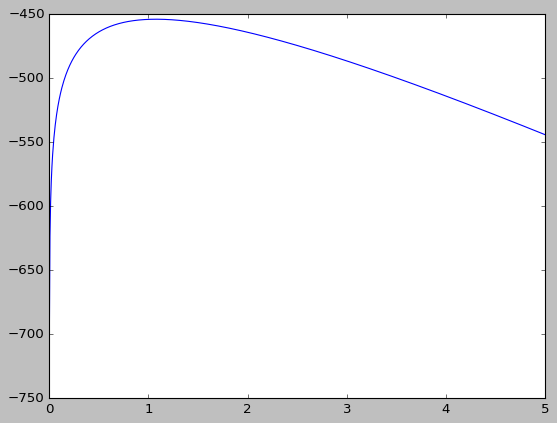

In [48]:
lin1 = np.linspace(0.001,5,750)
wTest = np.array([w[i] for i in range(len(w))])
gammaTest = np.array([gammaParameters[i] for i in range(len(gammaParameters))] )
gammaTest = np.delete(gammaTest,1)
print(gammaTest)
yVals = [posterior(n,p,k,np.concatenate(( np.insert(gammaTest,1,val) ,wTest)),rho) for val in lin1]
plt.plot(lin1,yVals)
plt.savefig("CoordinateWiseFunction.png")

In [10]:
resultGlobal = globalOpt(n,p,k,rho)
for i in range(50):
    resultGlobal = globalOpt(n,p,k,rho, w0 = resultGlobal[0])
    
print(resultGlobal)

(array([4.40548452e-01, 8.83754577e-01, 1.71477509e-01, 9.69479074e-02,
       1.34847482e+00, 5.92993753e+00, 1.30180489e+00, 4.04578983e-02,
       4.76081905e-01, 1.69644664e+00, 3.40176604e+00, 1.41355144e+00,
       7.17276617e+00, 1.00000000e-07, 1.43330294e+00, 4.33974946e+00,
       7.80395653e-01, 3.95162962e+00, 6.93135357e+00, 1.00000000e-07,
       2.91146176e+00, 5.31110830e+00, 1.00000000e-07, 8.14107319e-01,
       5.04856055e+00, 2.26799263e+00, 1.49013570e+00, 5.81396536e+00,
       1.00000000e-07, 5.74307362e+00, 4.13052593e+00, 3.81165714e-01,
       5.85272143e+00, 1.54245988e+00, 1.00000000e-07, 1.14290547e+00,
       6.86569263e+00, 1.00000000e-07, 6.83905314e+00, 3.26594886e+00,
       1.00000000e-07, 2.84857714e-01, 7.94170033e+00, 2.42754589e-01,
       3.94228441e+00, 7.80300713e+00, 1.00000000e-07, 3.69376775e+00,
       4.54404814e+00, 1.00000000e-07, 3.73297932e+00, 7.65893504e+00,
       2.06672182e+00, 1.35213010e+00, 6.70903419e+00, 1.52266282e+00,
     

In [11]:
eps = 0.00001
result = optimizeCoor(n,p,k,rho,eps)
print(result)


537.8962710258755
490.1908315253326
454.27325818815143
406.0954232155193
280.926845939474
Original: [9.45484494e-01 3.51288756e+00 8.89655788e-01 1.67263121e+00
 1.00000000e-12 1.00000000e-12 5.02831959e-01 1.00000000e-12
 1.00000000e-12 4.88177720e-01 1.00000000e-12 2.74134808e+00
 1.00000000e-12 1.00000000e-12 1.00000000e-12 7.10744796e-01
 1.00000000e-12 2.45597527e+00 3.26795458e-01 1.00000000e-12
 2.25388969e-01 1.00000000e-12 1.00000000e-12 1.00000000e-12
 4.01180323e-01 1.00000000e-12 1.03392208e-01 3.61517329e-01
 1.00000000e-12 9.41899022e-01 4.64581296e-01 1.00000000e-12
 1.00000000e-12 3.60751826e-01 1.00000000e-12 1.00230973e+00
 1.00000000e-12 1.00000000e-12 5.77653887e-01 4.57180493e-01
 1.00000000e-12 1.00000000e-12 3.46613261e-01 1.00000000e-12
 1.29508505e+00 2.50537572e-01 1.00000000e-12 5.94172733e-01
 1.03562802e-01 1.00000000e-12 1.00000000e-12 6.58353673e-01
 1.00000000e-12 6.62492831e-01 1.99388471e-01 1.00000000e-12
 3.10924739e-01 1.16965609e+00 1.00000000e-12 

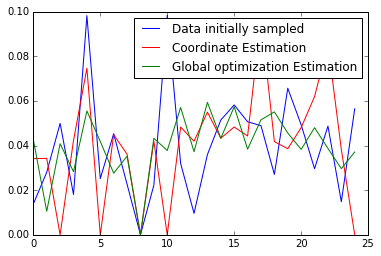

Ranking Gap Coordinate 6.8
Ranking Gap Global 6.8
AE Coordinate 0.024541696765785038
AE Global 0.01834159835125007


In [20]:
numInd = 8
strengthEstimated = normalizeStrength(n,computeStrength(n,p,result[0][(p+1):]))
strengths = normalizeStrength(n,computeStrength(n,p,w))
strengthEstimated = strengthEstimated.reshape((n*n,))
strengths = strengths.reshape((n*n,))
strengthGlb = normalizeStrength(n,computeStrength(n,p,resultGlobal[0][(p+1):]))
strengthGlb = strengthGlb.reshape((n*n,))
plt.plot([i for i in range(n)], strengths[numInd*n:(numInd+1)*n], '-b' ,label = 'Data initially sampled')
plt.plot([i for i in range(n)], strengthEstimated[numInd*n:(numInd+1)*n], '-r' , label = 'Coordinate Estimation')
plt.plot([i for i in range(n)], strengthGlb[numInd*n:(numInd+1)*n], '-g' ,label = 'Global optimization Estimation')
plt.legend()
#plt.title("Estimation of the link between the first individual with the others")
plt.savefig("LambdaEstimation")
plt.show()
print("Ranking Gap Coordinate", rankingGap(strengths[numInd*n:(numInd+1)*n],strengthEstimated[numInd*n:(numInd+1)*n],n))
print("Ranking Gap Global", rankingGap(strengths[numInd*n:(numInd+1)*n],strengthGlb[numInd*n:(numInd+1)*n],n))

print("AE Coordinate", AE(strengths[numInd*n:(numInd+1)*n],strengthEstimated[numInd*n:(numInd+1)*n],n))
print("AE Global", AE(strengths[numInd*n:(numInd+1)*n],strengthGlb[numInd*n:(numInd+1)*n],n))

[1.52365345 1.08558978 2.56030798 2.52707765]
[0.32176337 0.23479944 0.56571247 0.51465264 0.88509951 0.66674655
 1.87771106 0.41905614 0.52186606 0.21338366 0.67962515 0.59693194
 4.13175553 0.51773233 0.2055853  0.51362541 0.62328035 0.82599345
 1.41749317 0.71605595 0.70420526 0.54198408 0.45920622 0.69776539
 1.78311781 1.18483787 0.50583421 0.258146   0.86683711 0.67713052
 4.37129427 0.18326625 0.1744885  1.11132306 0.49662994 0.12545198
 0.26879889 0.06181121 0.4717199  1.38110288 0.02005031 0.93179067
 1.68282528 0.8815026  0.37634439 1.88900211 1.0681113  0.30779137
 2.15766725 0.17142811 0.2357176  1.21318486 1.40162882 0.39655376
 0.4900125  0.88333998 0.60794559 2.00913436 1.09762881 1.03555397
 1.53693957 0.83788874 0.63921474 0.72472131 0.70723023 0.60725866
 2.15515507 0.06600408 0.17626199 0.52713098 0.03682496 0.46902413
 1.80274549 1.12887435 0.19139265]
[[0.         0.03473189 0.04617006 0.0261865  0.07252257 0.03604057
  0.04731787 0.03132361 0.05266197 0.03098626 0

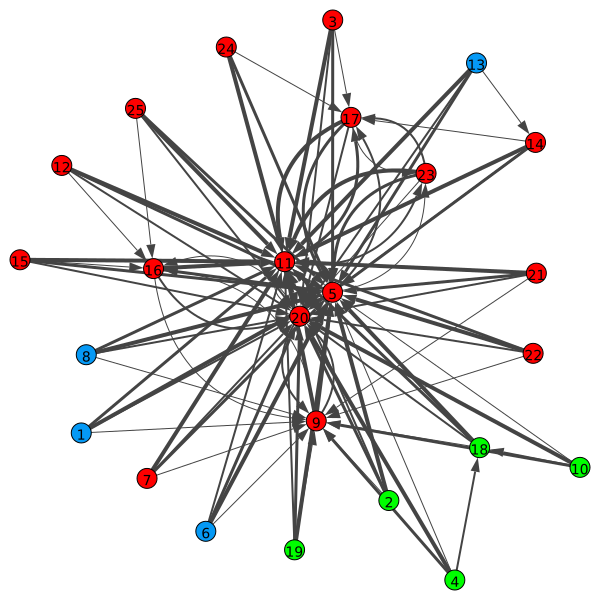

In [21]:
g = Graph(directed=True)
g.add_vertices(n)
print(gammaParameters)
print(w)
strengths = normalizeStrength(n,computeStrength(n,p,w))
print(strengths)
strengths = strengths.reshape((n*n,))
comm = w.reshape((n,p))
for i in range(n):
    listToSort = [i for i in range(n)]
    listStrengthOrigin_i = strengths[i*n : (i+1)*n]
    listSorted = sorted(listToSort, key=lambda x: listStrengthOrigin_i[x])
    listSorted.reverse()
    print(listSorted)
    for j in range(k):
        g.add_edge(i,listSorted[j], width=k-j)
g.vs["label"] = [i + 1 for i in range(n)]
colors = ["red", "green", (0.02, 0.6, 0.96)]
g.vs["color"] = [colors[np.argmax(comm[i])] for i in range(n)]
out = plot(g)
out.save("OriginalPlot.png")
out

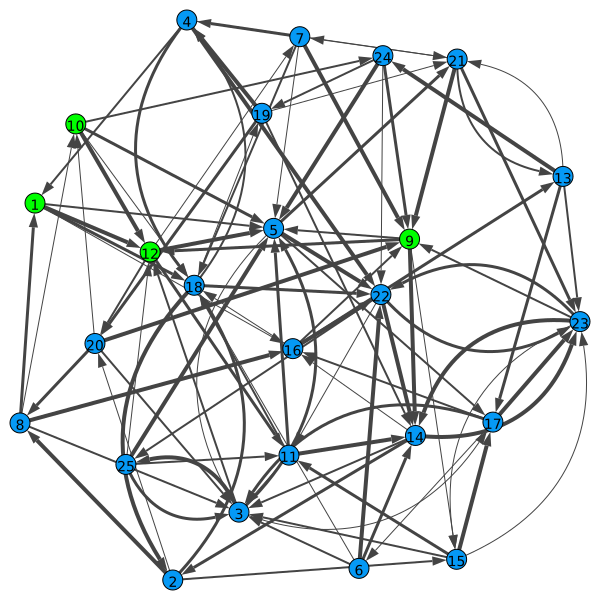

In [22]:
g = Graph(directed=True)
g.add_vertices(n)
for i in range(n):
    for j in range(k):
        g.add_edge(i,rho[i,j], width=k-j)
g.vs["label"] = [i + 1 for i in range(n)]
colors = ["red", "green", (0.02, 0.6, 0.96)]
g.vs["color"] = [colors[np.argmax((resultGlobal[0][(p+1):].reshape((n,p)))[i])] for i in range(n)]
out = plot(g)
out.save("OptimizationPlot.png")
out

### Evaluation

#### Fixed parameter prior

In [109]:
n = 15
k = 3
p = 3
a = 2
b = 2
eps = 0.000001




rho = computeRho(strengths,n,n-1)
rhoTest = rho[:,:k]
print(rhoTest)
#globalOpt(n,p,k,rho)
#optimizeCoor(n,p,k,rho,eps)

wCoor = optimizeCoorNoDegree(n,p,k,a,b,rho,eps)[0]
wGlb = globalOptNoDegree(n,p,k,a,b,rho)[0]
strCoor = computeStrength(n,p,wCoor)
strGlb = computeStrength(n,p,wGlb)
rhoCoor = computeRemainingRho(strCoor,n,rhoTest)[:,k:]
rhoGlb = computeRemainingRho(strGlb,n,rhoTest)[:,k:]
trueRho = rho[:,k:]
print(rhoCoor, trueRho)
print(mean([rankingGap(rhoGlb[i],rhoCoor[i],n-1-k) for i in range(n)]))
print(mean([rankingGap(rhoGlb[i],trueRho[i],n-1-k) for i in range(n)]))


/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in double_scalars
/home/pierre/.local/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in multiply


[[ 4  5  1]
 [ 3  0  2]
 [ 6  7  9]
 [ 8  6  5]
 [ 2 14 13]
 [12  8  0]
 [14  1  8]
 [ 2  4  0]
 [ 2  1 13]
 [ 2  0  4]
 [11  1 12]
 [ 8  9  7]
 [ 3  6  8]
 [ 1  3 11]
 [ 7 13  4]]
[[ 2  8  7  3  6 13 14  9 11 12 10]
 [ 8  6 13  4 12  5  7 11 14  9 10]
 [ 4  0  1  8 14 13 11  3  5 12 10]
 [ 1  2  0 12 13  4 11  7 14  9 10]
 [ 7  0  1  9  8  6 11  3  5 12 10]
 [ 1  3  2  6 13  4 11  7 14  9 10]
 [ 2  3  0  4 13 12  5  7 11  9 10]
 [ 1  9 14  8 13  6 11  3  5 12 10]
 [ 3  6  0 12  5  4 11  7 14  9 10]
 [ 7  1  8 14 13  6 11  3  5 12 10]
 [ 8  2  3  0  6 13  4  5  7 14  9]
 [ 2  1  4  0  3  6 13 14 12  5 10]
 [ 1  2  0 13  5  4 11  7 14  9 10]
 [ 8  2  0  4  6  7 12  5 14  9 10]
 [ 2  1  0  8  9  6  3 11  5 12 10]] [[11  9 13  6  3  8  7 10 14 12  2]
 [10  4  6 11 12  8  9  7  5 13 14]
 [ 1  8  4 11 10  5 13  3  0 14 12]
 [13 14  0 12  9 10  1  4  2 11  7]
 [11  3 12 10  6  9  1  0  5  7  8]
 [ 9 14  2 11 10  6 13  3  4  1  7]
 [ 4  2 10  0  3  5 12  7  9 13 11]
 [12 11  8  3 10  5 14  6 